In [1]:
#!pip install --quiet --user git+https://github.com/hmmlearn/hmmlearn
from hmmlearn import hmm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense,BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate,LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from scipy.stats import kurtosis
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_train=pd.read_hdf('dftrain.h5')

In [3]:
df_test=pd.read_hdf('dfvalid.h5')

In [4]:
df_test_y=pd.read_csv('dfvalid_groundtruth.csv')

In [5]:
df_test_y=pd.merge(df_test_y,df_test,left_index=True,right_index=True)
df_test_y
fcols=df_test_y.columns[2:61141]

In [6]:
s1=df_test_y[df_test_y['seqID']==1][fcols].T

In [7]:
df_test_y[fcols]

,0,1,2,3,4,5,6,7,8,9,...,61129,61130,61131,61132,61133,61134,61135,61136,61137,61138
0,0.070650,0.085524,0.076847,0.085524,0.120229,0.140061,0.107834,0.048340,0.014874,0.030987,...,-0.011155,0.019832,0.027268,0.016113,-0.002479,-0.027268,-0.053297,-0.063213,-0.044621,-0.006197
1,-0.300685,-0.882656,-1.733789,-2.181179,-1.942328,-1.719240,-1.981126,-2.323034,-2.325459,-2.349708,...,-0.423141,-1.277911,-1.316710,-1.635581,-2.340009,-3.252976,-3.522137,-2.593409,-2.422455,-3.724615
2,-0.056398,-0.152028,-0.058850,0.140994,0.170419,0.154480,0.270954,0.359228,0.334708,0.349420,...,0.029425,0.067432,0.082144,0.158159,0.210878,0.172871,0.145898,0.160611,0.140994,0.112795
3,0.030618,0.020412,0.058747,0.124712,0.155828,0.161553,0.167777,0.170515,0.165038,0.141141,...,-0.026386,-0.069451,-0.084884,-0.059991,-0.048292,-0.069700,-0.078412,-0.059991,-0.036841,-0.041322
4,-1.071597,-6.912540,-13.677612,-16.463519,-15.790084,-11.653620,-7.668311,-9.942997,-14.321553,-13.704648,...,-14.150737,-14.580850,-14.470250,-13.029984,-7.176752,-1.316148,-2.622464,-7.191499,-5.822509,-1.145331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,-18.291415,-18.288957,-18.285270,-18.282812,-18.280354,-18.276668,-18.271752,-18.268065,-18.268065,-18.270523,...,-19.504370,-19.501912,-19.499454,-19.496996,-19.492081,-19.490852,-19.490852,-19.493310,-19.495768,-19.499454
590,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,...,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138,-13.352138
591,0.031800,-0.143735,-0.059784,0.248039,0.283655,-0.010176,-0.153911,0.069960,0.283655,0.183167,...,-0.087768,0.155183,0.202247,-0.068688,-0.092856,0.304006,0.456646,0.061056,-0.226415,0.019080
592,-0.026635,-0.026635,-0.006721,0.009210,-0.008464,-0.036094,-0.039082,-0.026137,-0.017674,-0.017674,...,0.102807,0.089863,0.074180,0.059742,0.048043,0.047047,0.043313,0.033605,0.024146,0.025142


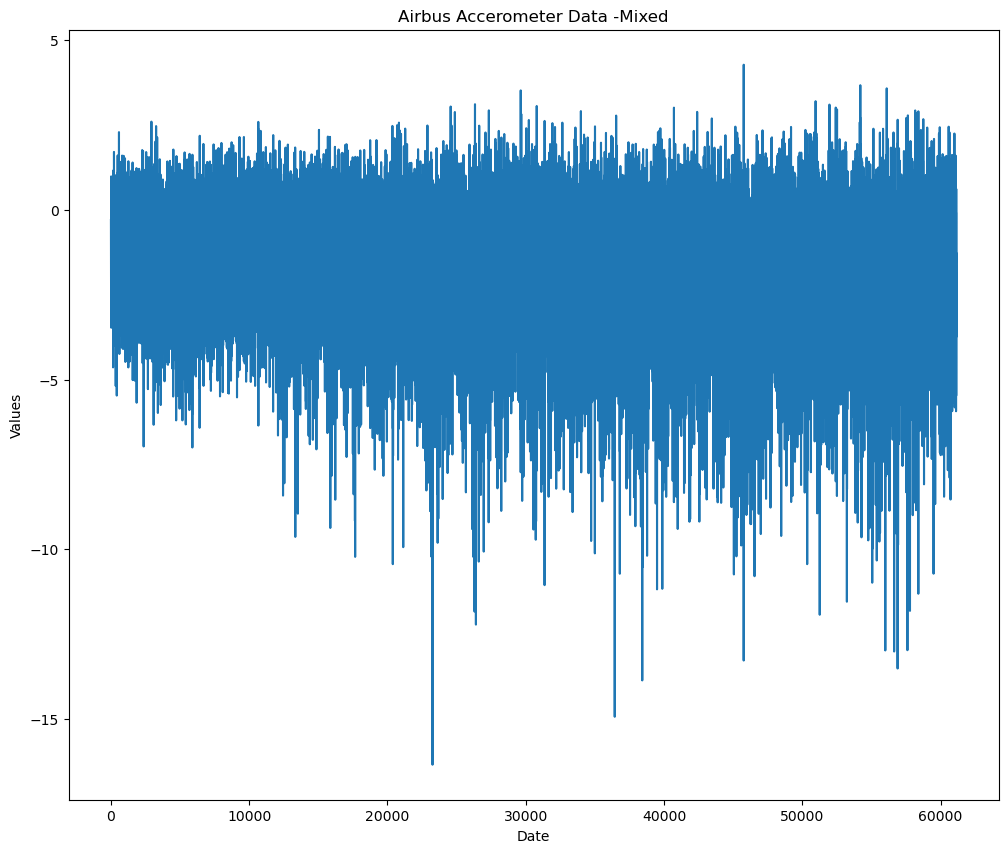

In [8]:
import matplotlib.pyplot as plt
 # Using a inbuilt style to change
# the look and feel of the plot
#plt.style.use("fivethirtyeight")

# setting figure size to 12, 10
plt.figure(figsize=(12, 10))

# Labelling the axes and setting
# a title
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Airbus Accerometer Data -Mixed")
plt.plot(np.array(s1))
#plt.plot(dataframe.rolling( window=2, min_periods=1).mean()["A"])

In [9]:
def down_sample_preprocess(df):
    dfret = pd.DataFrame()  # Initialize an empty DataFrame to store the processed data
    for i in range(0, len(df)):
        #print("Row: ", i)
        input = df[i:i + 1]  # Select a single row from the input DataFrame
        #print("Shape of input ",input.shape)
        data = input.copy()  # Create a copy of the selected row
        data = data.T  # Transpose the data (to have time series data in columns)
        data.index = pd.date_range(start='1/1/2018', periods=input.shape[1], freq='L')
        # Set the index of the transposed data as a date range starting from '1/1/2018',
        # with the number of periods equal to the length of the selected row, and with a frequency of 'L' (milliseconds)
        
        #print(data.head)
        df_t1 = data.resample('1024L').mean()  # Resample the data to a 1024L frequency and calculate the mean
        df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
        
        data_resample_mean = data.resample('1024L').mean()  # Resample the data to a 1024L frequency and calculate the mean
        level_shift = (data_resample_mean - data_resample_mean.shift(-1)).interpolate()  # Perform a level shift operation on the resampled data
        df_t2 = level_shift.resample('1024L').max()  # Resample the level shifted data to a 1024L frequency and calculate the maximum
        df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
        
        df_t3 = data.resample('1024L').apply(lambda x: kurtosis(x))  # Resample the data to a 1024L frequency and apply the kurtosis function
        df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
        
        df_train_c = df_t1.join(df_t2).join(df_t3)  # Join the resampled dataframes into a single dataframe
        df_train_c['s'] = range(0, len(df_train_c))  # Add a new column 's' with values ranging from 0 to the length of the dataframe
        df_train_c['id'] = i  # Add a new column 'id' with the value of the current row index
        
        df2 = df_train_c.pivot_table(index=['id'], columns=['s'], values=['v_avg', 'v_shift', 'v_kurt'])  # Pivot the dataframe to reshape it
        df2 = df2.sort_index(axis=1, level=1)  # Sort the columns in ascending order
        
        df2.columns = [f'{x}_{y}' for x, y in df2.columns]  # Rename the columns with a combination of the original column names and the index level values
        df2 = df2.reset_index()  # Reset the index of the dataframe
        
        if (len(dfret) == 0):
            dfret = df2  # If the resulting dataframe is empty, assign it to dfret
        else:
            dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
        
    return dfret  # Return the processed dataframe

In [10]:
df_train_ds=down_sample_preprocess(df_train)

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: Fut

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: F

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

In [44]:
feature_cols=df_train_ds.columns[1:]

In [45]:
feature_cols

Index(['v_avg_0', 'v_kurt_0', 'v_shift_0', 'v_avg_1', 'v_kurt_1', 'v_shift_1',
       'v_avg_2', 'v_kurt_2', 'v_shift_2', 'v_avg_3',
       ...
       'v_shift_56', 'v_avg_57', 'v_kurt_57', 'v_shift_57', 'v_avg_58',
       'v_kurt_58', 'v_shift_58', 'v_avg_59', 'v_kurt_59', 'v_shift_59'],
      dtype='object', length=180)

In [46]:
import copy

X_train = copy.copy(df_train_ds[feature_cols])


In [47]:
X_train

,v_avg_0,v_kurt_0,v_shift_0,v_avg_1,v_kurt_1,v_shift_1,v_avg_2,v_kurt_2,v_shift_2,v_avg_3,...,v_shift_56,v_avg_57,v_kurt_57,v_shift_57,v_avg_58,v_kurt_58,v_shift_58,v_avg_59,v_kurt_59,v_shift_59
0,0.039083,0.226365,-0.000119,0.039202,-0.059968,0.000122,0.039080,-0.270738,0.000191,0.038889,...,-0.000301,0.039324,-0.339576,0.000205,0.039119,0.084522,-0.000016,0.039135,-0.210907,-0.000016
0,0.007004,-1.321729,0.002645,0.004359,-1.186222,-0.003292,0.007651,-1.137968,0.006723,0.000928,...,-0.001154,0.001642,-1.410882,-0.001214,0.002856,-1.446154,-0.000433,0.003289,-1.443881,-0.000433
0,0.001349,-0.612774,-0.007591,0.008940,-0.958956,-0.003055,0.011996,0.225869,-0.009247,0.021243,...,0.002729,0.013707,-1.440003,0.000738,0.012970,-1.423950,0.000279,0.012690,-1.462096,0.000279
0,0.006611,-0.993685,0.003005,0.003606,-0.982437,-0.002150,0.005755,-1.442564,-0.000339,0.006095,...,-0.001692,0.006630,-0.281353,0.002150,0.004480,-0.335784,0.001589,0.002891,-0.423974,0.001589
0,0.028091,-1.362881,-0.002802,0.030893,-1.471487,0.009534,0.021359,-1.505843,-0.007856,0.029215,...,-0.050963,0.081051,-0.854220,0.006946,0.074105,-1.173144,0.048282,0.025823,-1.483825,0.048282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.003368,-1.025613,-0.002312,-0.001056,-1.124370,0.002675,-0.003731,-1.254513,0.004859,-0.008590,...,-0.006117,-0.006198,0.215145,-0.004021,-0.002178,-0.364072,0.005794,-0.007971,-0.291035,0.005794
0,-0.101016,-1.101169,-0.004787,-0.096228,-1.206431,-0.015390,-0.080838,-1.151161,-0.024534,-0.056304,...,-0.015568,-0.012238,5.696957,-0.005189,-0.007049,5.946993,-0.006699,-0.000350,0.631347,-0.006699
0,-0.005906,-1.302965,0.010242,-0.016149,-1.328469,0.013269,-0.029417,-1.284279,0.004528,-0.033945,...,0.001311,-0.024603,1.631476,-0.005967,-0.018636,3.702408,0.004036,-0.022672,-0.232383,0.004036
0,-0.027126,0.351068,-0.002088,-0.025038,-0.057128,0.001006,-0.026044,0.263710,-0.002614,-0.023430,...,0.001100,-0.025061,0.210643,-0.002909,-0.022152,0.471445,0.001305,-0.023457,-0.021528,0.001305


In [15]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [16]:
# The reparameterization trick
from tensorflow.math import reduce_prod

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [17]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 180)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 90)           16290       ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 60)           5460        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 60)           5460        ['dense[0][0]']                  
                                                                                            

In [18]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 60)]              0         
                                                                 
 dense_1 (Dense)             (None, 90)                5490      
                                                                 
 dense_2 (Dense)             (None, 180)               16380     
                                                                 
Total params: 21,870
Trainable params: 21,870
Non-trainable params: 0
_________________________________________________________________


In [19]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [20]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all
    total_loss = K.mean(reconstruction_loss + kl_loss)
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [21]:
from tensorflow.keras import optimizers
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=300,
                        batch_size=32)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 180)]             0         
                                                                 
 encoder (Functional)        (None, 60)                27210     
                                                                 
 decoder (Functional)        (None, 180)               21870     
                                                                 
Total params: 49,080
Trainable params: 49,080
Non-trainable params: 0
_________________________________________________________________
Train on 1677 samples
Epoch 1/300
1677/1677 [==============================] - 2s 962us/sample - loss: 2858.9383
Epoch 2/300
1677/1677 [==============================] - 0s 188us/sample - loss: 2418.4607
Epoch 3/300
1677/1677 [==============================] - 0s 219us/sample - loss: 1894.9167
Epoch 4/300
1677/1677 [=

1677/1677 [==============================] - 0s 243us/sample - loss: 736.1849
Epoch 82/300
1677/1677 [==============================] - 0s 196us/sample - loss: 735.5476
Epoch 83/300
1677/1677 [==============================] - 0s 195us/sample - loss: 734.7099
Epoch 84/300
1677/1677 [==============================] - 0s 187us/sample - loss: 735.7942
Epoch 85/300
1677/1677 [==============================] - 0s 139us/sample - loss: 734.9770
Epoch 86/300
1677/1677 [==============================] - 0s 198us/sample - loss: 733.0126
Epoch 87/300
1677/1677 [==============================] - 0s 171us/sample - loss: 736.0963
Epoch 88/300
1677/1677 [==============================] - 0s 207us/sample - loss: 732.4158
Epoch 89/300
1677/1677 [==============================] - 0s 203us/sample - loss: 733.9687
Epoch 90/300
1677/1677 [==============================] - 0s 146us/sample - loss: 734.3985
Epoch 91/300
1677/1677 [==============================] - 0s 202us/sample - loss: 735.4321
Epoch 92/300

1677/1677 [==============================] - 0s 230us/sample - loss: 722.4010
Epoch 171/300
1677/1677 [==============================] - 0s 249us/sample - loss: 722.2103
Epoch 172/300
1677/1677 [==============================] - 0s 203us/sample - loss: 722.9343
Epoch 173/300
1677/1677 [==============================] - 0s 181us/sample - loss: 723.6423
Epoch 174/300
1677/1677 [==============================] - 0s 243us/sample - loss: 723.4384
Epoch 175/300
1677/1677 [==============================] - 0s 223us/sample - loss: 722.6590
Epoch 176/300
1677/1677 [==============================] - 0s 175us/sample - loss: 721.7874
Epoch 177/300
1677/1677 [==============================] - 0s 219us/sample - loss: 723.5062
Epoch 178/300
1677/1677 [==============================] - 0s 191us/sample - loss: 723.5634
Epoch 179/300
1677/1677 [==============================] - 0s 214us/sample - loss: 723.0081
Epoch 180/300
1677/1677 [==============================] - 0s 223us/sample - loss: 721.4473
Ep

1677/1677 [==============================] - 0s 224us/sample - loss: 715.8837
Epoch 260/300
1677/1677 [==============================] - 0s 185us/sample - loss: 716.7612
Epoch 261/300
1677/1677 [==============================] - 0s 192us/sample - loss: 717.7529
Epoch 262/300
1677/1677 [==============================] - 0s 196us/sample - loss: 713.0715
Epoch 263/300
1677/1677 [==============================] - 0s 153us/sample - loss: 716.0621
Epoch 264/300
1677/1677 [==============================] - 0s 240us/sample - loss: 717.0765
Epoch 265/300
1677/1677 [==============================] - 0s 268us/sample - loss: 717.5359
Epoch 266/300
1677/1677 [==============================] - 0s 166us/sample - loss: 717.2709
Epoch 267/300
1677/1677 [==============================] - 0s 220us/sample - loss: 714.1775
Epoch 268/300
1677/1677 [==============================] - 0s 246us/sample - loss: 716.2710
Epoch 269/300
1677/1677 [==============================] - 0s 148us/sample - loss: 717.3704
Ep

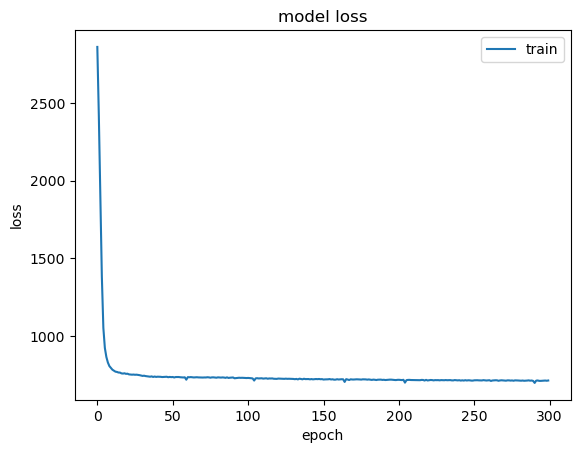

In [22]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [25]:
X_train_pred = vae_model.predict(X_train)

In [26]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.17205153484952332
median error 0.14290020686096555
99Q: 0.4693433573500697
setting threshold on 0.4693433573500697 


In [27]:
df_test_ds=down_sample_preprocess (df_test)

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t2 = df_t2.set_axis(['v_shift'], axis=1, inplace=False)  # Set the column name as 'v_shift'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:23: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t3 = df_t3.set_axis(['v_kurt'], axis=1, inplace=False)  # Set the column name as 'v_kurt'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfret = dfret.append(df2)  # If the resulting dataframe is not empty, append df2 to dfret
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_t1 = df_t1.set_axis(['v_avg'], axis=1, inplace=False)  # Set the column name as 'v_avg'
C:\Users\SAIL\AppData\Local\Temp\ipykernel_15080\1025938692.py:20: Futur

In [35]:
import copy
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

X_test = copy.copy(df_test_ds.drop('id', axis=1))
X_test

,v_avg_0,v_kurt_0,v_shift_0,v_avg_1,v_kurt_1,v_shift_1,v_avg_2,v_kurt_2,v_shift_2,v_avg_3,...,v_shift_56,v_avg_57,v_kurt_57,v_shift_57,v_avg_58,v_kurt_58,v_shift_58,v_avg_59,v_kurt_59,v_shift_59
0,0.052551,-0.013829,0.047319,0.005231,-0.265840,0.003807,0.001425,-0.211097,0.017932,-0.016508,...,0.000500,0.020830,0.103334,-0.002450,0.023280,-0.198569,-0.000735,0.024015,-0.087598,-0.000735
0,-1.547501,-0.259274,-0.028314,-1.519187,-0.571397,-0.123558,-1.395629,-0.359493,0.098209,-1.493838,...,-0.025616,-2.052561,1.548797,0.041496,-2.094057,1.736899,-0.418309,-1.675748,0.857584,-0.418309
0,-0.005793,-0.743499,0.003409,-0.009201,-0.467587,0.000254,-0.009455,-0.816908,-0.000997,-0.008458,...,-0.003528,-0.007797,-0.958179,-0.002957,-0.004839,-1.031796,0.003339,-0.008179,-1.039119,0.003339
0,0.009589,0.985710,-0.002740,0.012329,0.709863,0.021882,-0.009554,-0.320198,-0.019863,0.010310,...,0.005830,-0.002377,-0.367167,-0.000926,-0.001451,-0.008531,-0.002206,0.000755,-0.359937,-0.002206
0,-7.717476,0.009049,1.347925,-9.065401,0.131090,0.351513,-9.416914,-0.159924,-0.822680,-8.594235,...,-0.656629,-5.617131,-0.095056,0.744365,-6.361496,0.612225,-0.530261,-5.831235,-0.164034,-0.530261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-18.253942,-0.907617,0.003376,-18.257318,-0.873050,0.051236,-18.308554,-1.026898,0.101140,-18.409693,...,0.013098,-19.473189,-0.431292,0.010915,-19.484105,0.384691,0.018625,-19.502729,-0.590998,0.018625
0,-13.352138,NaN,0.000000,-13.352138,NaN,0.000000,-13.352138,NaN,0.000000,-13.352138,...,0.000000,-13.352138,NaN,0.000000,-13.352138,NaN,0.000000,-13.352138,NaN,0.000000
0,0.027820,-0.210869,-0.001724,0.029544,-0.262780,0.003150,0.026394,-0.472267,0.002887,0.023507,...,-0.010592,0.171247,-0.016263,0.007069,0.164178,0.093733,0.003527,0.160651,0.132821,0.003527
0,0.015399,-0.151603,0.018226,-0.002828,-0.350699,-0.011383,0.008555,-0.573774,0.009822,-0.001267,...,-0.012490,0.009585,-0.643038,-0.018566,0.028151,-0.989707,-0.033158,0.061309,-0.764554,-0.033158


In [36]:
Y=pd.read_csv('dfvalid_groundtruth.csv')
Y=Y['anomaly']
Y=Y.values
Y

array([0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0.

In [37]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Assuming the 'predictions' variable contains the data with shape (594, 2880)
predictions=vae_model.predict(X_test)
# Handle missing values by replacing NaN with the mean of non-missing values
imputer = SimpleImputer(strategy='mean')
predictions_filled = imputer.fit_transform(predictions)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=1)
vector_reduced = pca.fit_transform(predictions_filled)

# Reshape the reduced vector to (594,)
Y_pred = vector_reduced.reshape(594,)

print(Y_pred.shape)
Y_pred


(594,)


array([-5.03569365e-01,  2.63227987e+00, -5.01927853e-01, -4.98726636e-01,
       -4.98702705e-01,  3.37381673e+00, -5.00492632e-01, -5.00016987e-01,
        3.72502184e+00, -4.99031007e-01, -4.98718649e-01, -4.99530733e-01,
       -4.98701751e-01, -5.07217765e-01, -4.98702705e-01, -5.00157058e-01,
       -4.98702705e-01,  5.88280344e+00, -4.97455090e-01, -5.04525721e-01,
       -4.99524713e-01,  7.59324781e-09, -4.98801380e-01, -4.96641219e-01,
       -1.16812170e+00,  1.72915828e+00, -4.98762518e-01, -2.00825796e-01,
        7.59324781e-09, -4.98736173e-01, -2.75803924e-01, -4.98715550e-01,
        2.92331648e+00, -5.02309918e-01, -4.98702615e-01, -5.03035307e-01,
       -4.98702705e-01, -4.98710066e-01, -4.98729706e-01, -4.98825192e-01,
       -4.98703182e-01, -4.98720527e-01, -4.98702705e-01,  7.59324781e-09,
        4.59580517e+00, -4.98716533e-01, -4.99722540e-01, -4.98779893e-01,
       -5.00278354e-01, -4.99296248e-01, -4.98970866e-01, -4.81707275e-01,
       -5.00085652e-01, -

In [38]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Y_pred_sigmoid = sigmoid(Y_pred)
print(Y_pred_sigmoid)


[0.3767022  0.9329104  0.37708774 0.37783998 0.3778456  0.96687615
 0.3774249  0.37753665 0.97645515 0.37776843 0.37784183 0.37765095
 0.37784582 0.37584594 0.3778456  0.37750378 0.3778456  0.99722075
 0.37813893 0.3764777  0.37765238 0.5        0.3778224  0.37833032
 0.23719467 0.8493047  0.37783152 0.44996166 0.5        0.37783772
 0.4314828  0.37784255 0.94898707 0.376998   0.37784562 0.37682763
 0.3778456  0.37784386 0.3778392  0.3778168  0.3778455  0.37784138
 0.3778456  0.5        0.9900068  0.37784234 0.37760586 0.37782744
 0.37747523 0.37770605 0.37778255 0.38184905 0.37752056 0.3778456
 0.5        0.37785032 0.377647   0.37785    0.99113464 0.9775283
 0.37727165 0.37784582 0.37768564 0.3778456  0.3778431  0.37769726
 0.3778456  0.37782356 0.37782925 0.99578494 0.38072568 0.377793
 0.37783834 0.3778456  0.3777546  0.37783998 0.3778452  0.40415508
 0.3778456  0.5        0.47625872 0.5        0.3778456  0.41968012
 0.37775844 0.5        0.37781093 0.3775757  0.37783143 0.3777024


In [39]:
Y

array([0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0.

In [40]:
import numpy as np

mse = np.mean((Y_pred_sigmoid - Y) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.21843352743947203


In [41]:
epsilon = 1e-15  # small value to avoid division by zero
loss = -(Y * np.log(Y_pred_sigmoid + epsilon) + (1 - Y) * np.log(1 - Y_pred_sigmoid + epsilon))#Binary Cross-Entropy Loss
mean_loss = np.mean(loss)
print("Binary Cross-Entropy Loss:", mean_loss)
loss

Binary Cross-Entropy Loss: 0.6160527056940324


array([4.72730845e-01, 6.94461390e-02, 4.73349571e-01, 4.74557966e-01,
       9.73269701e-01, 3.36848684e-02, 4.73891020e-01, 4.74070549e-01,
       2.38264576e-02, 4.74442899e-01, 4.74560916e-01, 4.74254221e-01,
       9.73269045e-01, 9.78575945e-01, 9.73269701e-01, 4.74017680e-01,
       9.73269701e-01, 2.78311456e-03, 4.75038528e-01, 4.72370774e-01,
       4.74256516e-01, 6.93147182e-01, 4.74529684e-01, 4.75346446e-01,
       1.43887413e+00, 1.63337290e-01, 4.74544346e-01, 7.98592865e-01,
       6.93147182e-01, 4.74554330e-01, 5.64723670e-01, 4.74562079e-01,
       5.23601100e-02, 4.73205566e-01, 4.74567056e-01, 4.72932070e-01,
       9.73269701e-01, 4.74564195e-01, 4.74556714e-01, 4.74520683e-01,
       4.74566877e-01, 4.74560171e-01, 9.73269701e-01, 6.93147182e-01,
       1.00434627e-02, 4.74561691e-01, 4.74181712e-01, 4.74537730e-01,
       4.73971903e-01, 9.73639011e-01, 4.74465698e-01, 9.62729931e-01,
       4.74044681e-01, 9.73269701e-01, 6.93147182e-01, 9.73257124e-01,
      

The MSE provides a measure of the average squared difference between the predicted and actual values, while the binary cross-entropy loss quantifies the dissimilarity between the predicted probabilities and the true binary labels.

In [42]:
anomalies = (loss > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.877104377104377

In [43]:

from sklearn.metrics import classification_report
print(classification_report(Y, anomalies))

              precision    recall  f1-score   support

         0.0       0.12      0.03      0.05       297
         1.0       0.45      0.78      0.57       297

    accuracy                           0.41       594
   macro avg       0.29      0.41      0.31       594
weighted avg       0.29      0.41      0.31       594



Benefit of Batch normilization :
1- Improved training speed and stability: Batch normalization helps accelerate the training process by reducing the internal covariate shift problem. It normalizes the inputs to each layer to have zero mean and unit variance, which helps stabilize the training process and allows higher learning rates. This enables faster convergence and reduces the likelihood of getting stuck in training plateaus or local optima.

2- Reduced sensitivity to initialization: Batch normalization reduces the dependence of the network on the initialization of the weights. It helps alleviate the vanishing gradient problem and allows the network to be more robust to different weight initializations. This can lead to improved performance and faster convergence.

3- Regularization effect: Batch normalization has a slight regularization effect, similar to dropout. It introduces some noise to the activations during training, which helps reduce overfitting. This regularization effect can lead to better generalization performance on unseen data.

4- Increased model generalization: Batch normalization reduces the internal covariate shift by normalizing the activations. This can help the model generalize better to unseen data, as it reduces the dependence of the network on specific training examples and makes the network more invariant to variations in the input.

Overall, batch normalization is a powerful technique that can improve the training speed, stability, and generalization performance of deep neural networks. It has become a standard component in many neural network architectures.

In [201]:
#encoder RNN based VAE
from keras.layers import LSTM, BatchNormalization, Dropout

inputs = Input(shape=input_shape, name='encoder_input')
x = Reshape((1, input_shape[0]))(inputs)
x = LSTM(intermediate_dim, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, z, name='encoder_RVAE')
encoder.summary()


Model: "encoder_RVAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 2880)]       0           []                               
                                                                                                  
 reshape_8 (Reshape)            (None, 1, 2880)      0           ['encoder_input[0][0]']          
                                                                                                  
 lstm_8 (LSTM)                  (None, 1440)         24888960    ['reshape_8[0][0]']              
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 1440)        5760        ['lstm_8[0][0]']                 
 rmalization)                                                                          

In [202]:
# Decoder RVAE model
from keras.layers import LSTM, BatchNormalization, Dropout

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Reshape((1, intermediate_dim))(x)
x = LSTM(intermediate_dim, activation='relu', return_sequences=True)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder_RVAE')
decoder.summary()


Model: "decoder_RVAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 960)]             0         
                                                                 
 dense_17 (Dense)            (None, 1440)              1383840   
                                                                 
 reshape_9 (Reshape)         (None, 1, 1440)           0         
                                                                 
 lstm_9 (LSTM)               (None, 1, 1440)           16594560  
                                                                 
 batch_normalization_9 (Batc  (None, 1, 1440)          5760      
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 1, 1440)           0         
                                                      

In [203]:
# full VAE model
outputs = decoder(encoder(inputs))
rvae_model = Model(inputs, outputs, name='RNN_vae_mlp')

In [204]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all
    total_loss = K.mean(reconstruction_loss + kl_loss)
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [ ]:
from tensorflow.keras import optimizers
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

rvae_model.compile(optimizer=opt, loss=vae_loss)
rvae_model.summary()
# Finally, we train the model:
results = rvae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=100,
                        batch_size=32)

Model: "RNN_vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 2880)]            0         
                                                                 
 encoder_RVAE (Functional)   (None, 960)               27661440  
                                                                 
 decoder_RVAE (Functional)   (None, 2880)              22134240  
                                                                 
Total params: 49,795,680
Trainable params: 49,789,920
Non-trainable params: 5,760
_________________________________________________________________
Train on 1677 samples
Epoch 1/100
1677/1677 [==============================] - 58s 35ms/sample - loss: 3567933138.6156
Epoch 2/100
1677/1677 [==============================] - 25s 15ms/sample - loss: 122756242604.6697
Epoch 3/100
1677/1677 [==============================] - 25s 15ms/sample - loss: 6285

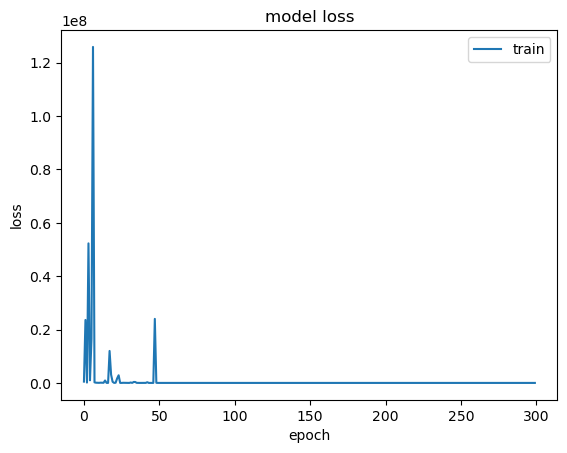

In [167]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [168]:
X_train_pred = rvae_model.predict(X_train)

C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [169]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.17396152681288965
median error 0.14497884930090388
99Q: 0.48372873793629156
setting threshold on 0.48372873793629156 


In [170]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Assuming the 'predictions' variable contains the data with shape (594, 2880)
predictions=rvae_model.predict(X_test)
# Handle missing values by replacing NaN with the mean of non-missing values
imputer = SimpleImputer(strategy='mean')
predictions_filled = imputer.fit_transform(predictions)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=1)
vector_reduced = pca.fit_transform(predictions_filled)

# Reshape the reduced vector to (594,)
Y_pred = vector_reduced.reshape(594,)

print(Y_pred.shape)
Y_pred

(594,)


array([-1.5688701e+00,  5.1384096e+00, -1.5676953e+00, -1.5711529e+00,
       -1.3291550e+00,  5.4966474e+00, -1.5699325e+00, -1.5708250e+00,
        8.2991743e+00, -1.5729054e+00, -1.5705909e+00, -1.5708811e+00,
        4.0637412e+00, -1.5666376e+00, -1.3488081e+00, -1.5732737e+00,
       -1.5473143e+00,  8.3385000e+00, -1.5662200e+00, -1.5685394e+00,
       -1.5659001e+00,  6.7002269e-08, -1.5622289e+00, -1.5715026e+00,
        6.0232389e-01,  7.4147549e+00, -1.5143126e+00,  5.1246638e+00,
        6.7002269e-08, -1.5715171e+00, -1.5635449e+00, -1.5617567e+00,
        6.0082917e+00, -1.5500411e+00, -1.5572121e+00, -1.5596015e+00,
       -1.4008267e+00, -1.5736732e+00, -1.5703019e+00, -1.5695595e+00,
       -1.5704446e+00, -1.5630975e+00, -1.5721065e+00,  6.7002269e-08,
        4.9865866e+00, -1.5656223e+00, -1.5702732e+00, -1.5715636e+00,
       -1.5581373e+00, -1.5683740e+00, -1.5724689e+00, -1.5748184e+00,
       -1.5560102e+00, -9.8493737e-01,  6.7002269e-08,  4.4788175e+00,
      

In [171]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Y_pred_sigmoid = sigmoid(Y_pred)
print(Y_pred_sigmoid)

[0.17237754 0.9941672  0.1725452  0.1720521  0.20929918 0.9959163
 0.17222603 0.17209882 0.9997514  0.1718026  0.17213216 0.17209081
 0.9831057  0.17269626 0.20606531 0.17175022 0.17547451 0.9997609
 0.17275593 0.17242472 0.17280166 0.5        0.17332704 0.17200229
 0.6461878  0.9993981  0.18030053 0.994087   0.5        0.17200023
 0.17313857 0.17339471 0.9975477  0.17508033 0.17404705 0.17370382
 0.19768496 0.17169337 0.17217337 0.17227921 0.17215303 0.17320263
 0.1719163  0.5        0.9932174  0.17284136 0.17217745 0.1719936
 0.17391409 0.1724483  0.17186472 0.17153057 0.1742199  0.2719132
 0.5        0.9887805  0.17209743 0.99724114 0.99962616 0.99345785
 0.17204762 0.17151496 0.17351706 0.17458661 0.17692278 0.17249554
 0.24943963 0.1728893  0.17244156 0.99976844 0.17663534 0.17275403
 0.17316243 0.17169835 0.17178322 0.17178455 0.17254256 0.17377736
 0.17151496 0.5        0.17287493 0.5        0.17151496 0.95642364
 0.17312594 0.5        0.17216845 0.17359596 0.17207451 0.17755349

In [172]:
import numpy as np

mse = np.mean((Y_pred_sigmoid - Y) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.1979246284857963


In [173]:
epsilon = 1e-15  # small value to avoid division by zero
loss = -(Y * np.log(Y_pred_sigmoid + epsilon) + (1 - Y) * np.log(1 - Y_pred_sigmoid + epsilon))#Binary Cross-Entropy Loss
mean_loss = np.mean(loss)
print("Binary Cross-Entropy Loss:", mean_loss)
loss

Binary Cross-Entropy Loss: 0.5707348260644225


array([1.89198181e-01, 5.84986852e-03, 1.89400792e-01, 1.88805029e-01,
       1.56399059e+00, 4.09205398e-03, 1.89015120e-01, 1.88861474e-01,
       2.48641882e-04, 1.88503727e-01, 1.88901722e-01, 1.88851833e-01,
       1.70386173e-02, 1.75622094e+00, 1.57956207e+00, 1.88440472e-01,
       1.74026144e+00, 2.39102810e-04, 1.89655527e-01, 1.89255223e-01,
       1.89710796e-01, 6.93147182e-01, 1.90346107e-01, 1.88744918e-01,
       4.36665148e-01, 6.02068903e-04, 1.98817506e-01, 5.93057042e-03,
       6.93147182e-01, 1.88742399e-01, 1.90118149e-01, 1.90427944e-01,
       2.45532580e-03, 1.92469224e-01, 1.91217467e-01, 1.90801963e-01,
       1.62108064e+00, 1.88371882e-01, 1.88951537e-01, 1.89079434e-01,
       1.88926920e-01, 1.90195635e-01, 1.76074755e+00, 6.93147182e-01,
       6.80569746e-03, 1.89758793e-01, 1.88956439e-01, 1.88734412e-01,
       1.91056490e-01, 1.75765777e+00, 1.88578784e-01, 1.76299369e+00,
       1.91426769e-01, 1.30227232e+00, 6.93147182e-01, 1.12829152e-02,
      

In [174]:
anomalies = (loss > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.3148148148148148

In [175]:

from sklearn.metrics import classification_report
print(classification_report(Y, anomalies))

              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84       297
         1.0       0.99      0.63      0.77       297

    accuracy                           0.81       594
   macro avg       0.86      0.81      0.80       594
weighted avg       0.86      0.81      0.80       594



C:\Users\SAIL\anaconda3\envs\fault\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


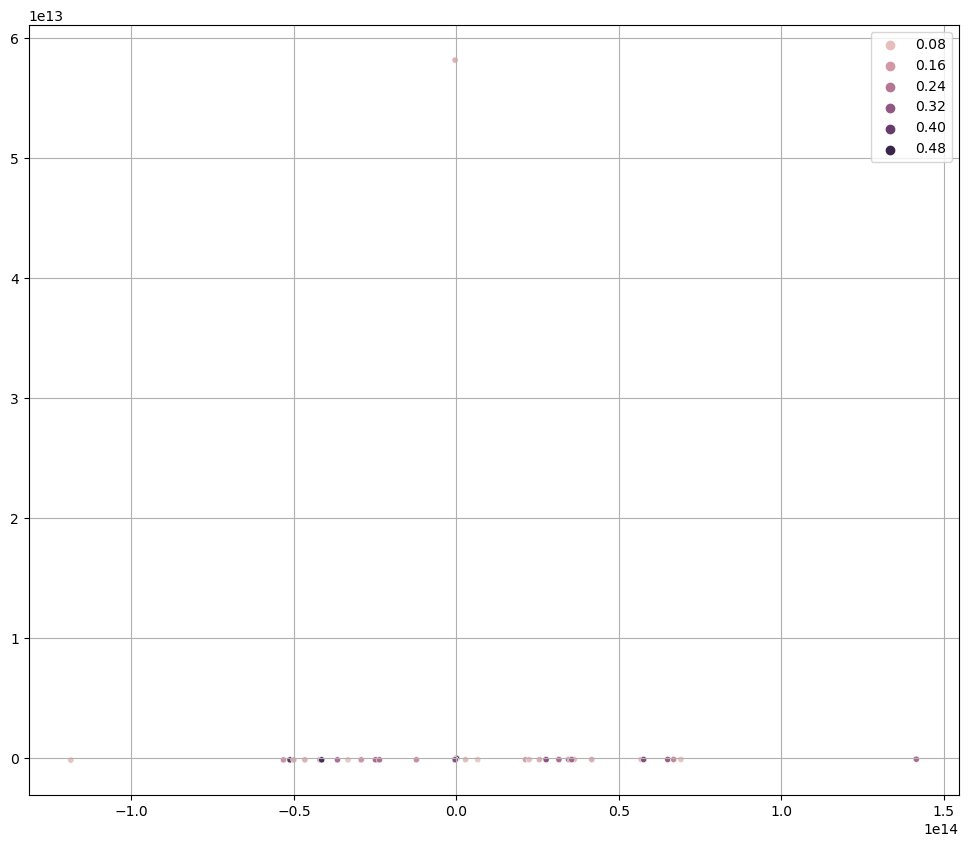

In [152]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

X_encoded = encoder.predict(X_test)

# Handle missing values by replacing NaN with the mean of non-missing values
imputer = SimpleImputer(strategy='mean')
X_encoded = imputer.fit_transform(X_encoded)

pca = PCA(n_components=2)
X_encoded = pca.fit_transform(X_encoded)

# Subset mae_vector to match the length of X_encoded
mae_vector_subset = mae_vector[:len(X_encoded)]

plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_encoded[:, 0], y=X_encoded[:, 1], s=20, hue=mae_vector_subset)
plt.grid()
plt.show()


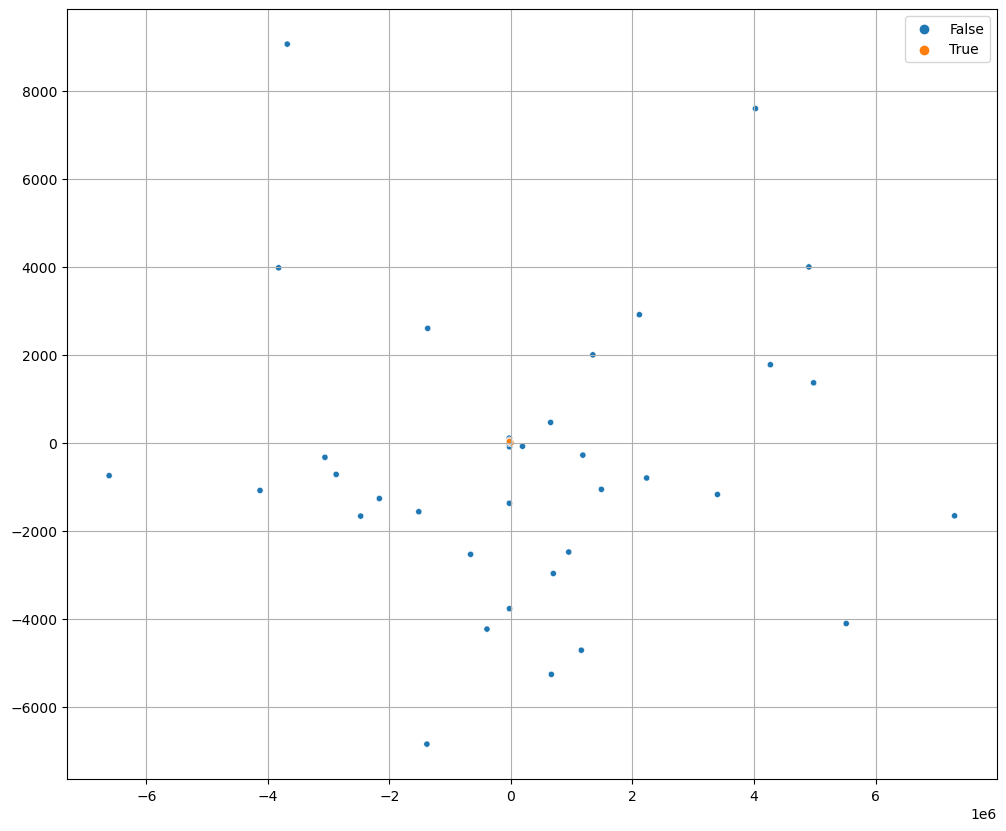

In [224]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_encoded[:, 0], y=X_encoded[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()